<a href="https://colab.research.google.com/github/onuralpArsln/MlAiTutorialProjects/blob/main/10-Pix2Pix/pix2pixprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Görsel işlemeler için çözünürlük arttırma

Bu çalışmada amaç elimizdeki düşük çözünürlüklü görüntüleri yüksek çözünürlükl hale getiren bir model oluşturmak istiyoruz.

In [1]:
import keras
from keras import layers
from keras import ops
from keras.utils import load_img
from keras.utils import array_to_img
from keras.utils import img_to_array
from keras.preprocessing import image_dataset_from_directory
import tensorflow as tf  #  only for data preprocessing
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.data import Dataset

import math
from IPython.display import display
import matplotlib.pyplot as plt
from IPython.display import clear_output


from tensorflow.keras.mixed_precision import set_global_policy



Burada aslında 1000 adet görsel olan basit bir dataset indiriyoruz. Manuel olarak onları düşük boyuta getirip sonrasında büyük boyutlu halleri ile eşleyerek yapay zeka eğitiminde kullancağız.

In [4]:
!wget -q "https://github.com/onuralpArsln/MlAiTutorialProjects/raw/refs/heads/main/10-Pix2Pix/archiveExpand.zip"


In [5]:
!unzip -q archiveExpand.zip

In [6]:
import gc
import tensorflow as tf
# Clear any previous sessions to free up RAM
tf.keras.backend.clear_session()
gc.collect()
import tensorflow as tf
tf.config.optimizer.set_jit(False)  # Disable XLA
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=0"


In [11]:
# Define paths
image_folder = "archive"  # Update with actual path
DOWNSCALE_FACTOR = 4  # 4 64*64 yapar, 8 ise 32

# Load images and create dataset
TARGET_SIZE = (256, 256)  # Adjust as neede
TARGET_SIZE_LOW = (256//DOWNSCALE_FACTOR, 256//DOWNSCALE_FACTOR)

BATCH_SIZE = 16
AUGMENT_LEVEL=2


low_res_images, high_res_images = [], []

for img_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, img_name)

    # Load and resize high-res image
    high_res = img_to_array(load_img(img_path, target_size=TARGET_SIZE))

    # Create low-res image (downscale by factor of 4)
    low_res = cv2.resize(high_res, (TARGET_SIZE_LOW[0], TARGET_SIZE_LOW[1]),
                          interpolation=cv2.INTER_CUBIC)

    # Store normalized versions for both original and flipped images
    low_res_images.append(low_res / 255.0)
    high_res_images.append(high_res / 255.0)
    if AUGMENT_LEVEL>=1:
        # Add augmented (flipped) versions to the dataset
        flipped_low_res = np.fliplr(low_res)
        flipped_high_res = np.fliplr(high_res)
        # Append the flipped images
        low_res_images.append(flipped_low_res / 255.0)
        high_res_images.append(flipped_high_res / 255.0)
    if AUGMENT_LEVEL>=2:
        # Apply 90° rotation
        rotated_90_low_res = np.rot90(low_res, k=1)  # 90 degrees
        rotated_90_high_res = np.rot90(high_res, k=1)
        low_res_images.append(rotated_90_low_res / 255.0)
        high_res_images.append(rotated_90_high_res / 255.0)
    if AUGMENT_LEVEL>=3:
        # Apply 180° rotation
        rotated_180_low_res = np.rot90(low_res, k=2)  # 180 degrees
        rotated_180_high_res = np.rot90(high_res, k=2)
        low_res_images.append(rotated_180_low_res / 255.0)
        high_res_images.append(rotated_180_high_res / 255.0)
    if AUGMENT_LEVEL>=4:
        # Apply Gaussian Blur
        blurred_low_res = cv2.GaussianBlur(low_res, (5, 5), 0)  # (5,5) kernel
        blurred_high_res = cv2.GaussianBlur(high_res, (5, 5), 0)
        low_res_images.append(blurred_low_res / 255.0)
        high_res_images.append(blurred_high_res / 255.0)




# Convert to NumPy arrays
low_res_images = np.array(low_res_images, dtype=np.float32)
high_res_images = np.array(high_res_images, dtype=np.float32)

# Create dataset
dataset = tf.data.Dataset.from_tensor_slices((low_res_images, high_res_images))
dataset = dataset.batch(BATCH_SIZE).shuffle(100).prefetch(tf.data.experimental.AUTOTUNE)
print(dataset.element_spec)


total_elements = sum(1 for _ in dataset)
total_images = total_elements * BATCH_SIZE
print(f"Total images in dataset: {total_images}")


(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))
Total images in dataset: 4608


In [8]:
print(dataset.element_spec)

(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))


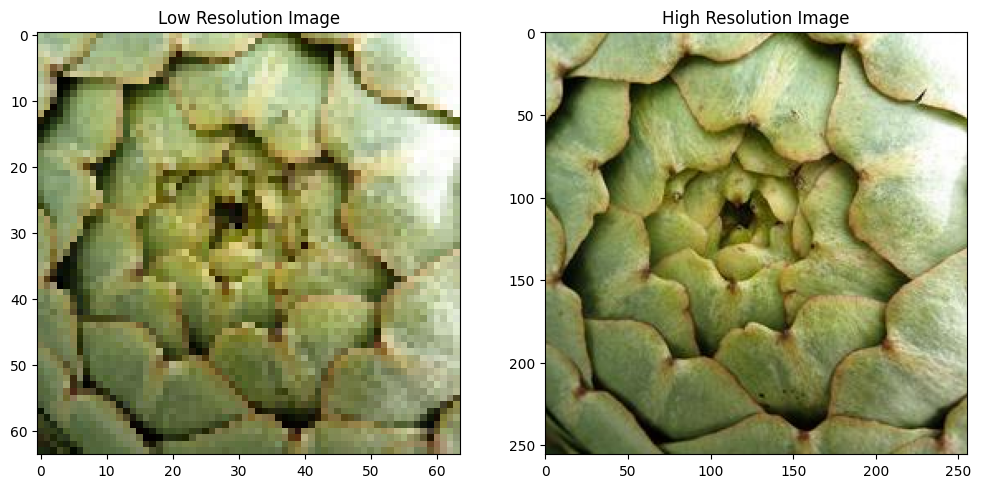

In [12]:
for low_res_batch, high_res_batch in dataset.take(1):  # Taking one batch
    # Take the first image from the batch
    low_res_image = np.clip(low_res_batch[0].numpy(), 0.0, 1.0)
    high_res_image = np.clip(high_res_batch[0].numpy(), 0.0, 1.0)

    # Plot both low-res and high-res images
    plt.figure(figsize=(12, 6))

    # Low resolution image
    plt.subplot(1, 2, 1)
    plt.imshow(low_res_image)
    plt.title("Low Resolution Image")

    # High resolution image
    plt.subplot(1, 2, 2)
    plt.imshow(high_res_image)
    plt.title("High Resolution Image")

    plt.show()


In [10]:
# 64 -> 256 modeli
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Add, Input, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Model

def build_upscaler():
    # Input layer (Low-resolution 64x64x3)
    inputs = Input(shape=(64, 64, 3))  # Input size: (64, 64, 3) - 64x64 image with 3 channels (RGB)

    # Initial convolution block (feature extraction)
    x = Conv2D(64, (9, 9), padding="same")(inputs)  # Convolution with a kernel of size (9, 9), 64 filters
    x = LeakyReLU(alpha=0.2)(x)  # Activation using LeakyReLU to prevent vanishing gradients
    x = BatchNormalization()(x)  # Batch normalization to stabilize training

    # Size after this block: (64, 64, 64) - The image is still 64x64, but the number of channels has increased to 64

    # Feature extraction block with more filters
    x = Conv2D(128, (5, 5), padding="same")(x)  # Convolution with kernel size (5, 5), 128 filters
    x = LeakyReLU(alpha=0.2)(x)  # LeakyReLU activation
    x = BatchNormalization()(x)  # Batch normalization to help with faster convergence

    # Size after this block: (64, 64, 128) - The image is still 64x64, but the number of channels is now 128

    # Upscaling to 128x128 using transposed convolutions
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")(x)  # Transposed conv: 64x64 → 128x128
    x = LeakyReLU(alpha=0.2)(x)  # LeakyReLU activation
    x = BatchNormalization()(x)  # Batch normalization

    # Size after this block: (128, 128, 128) - Image size has increased to 128x128 with 128 channels

    # Further upscaling to 256x256
    x = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same")(x)  # Transposed conv: 128x128 → 256x256
    x = LeakyReLU(alpha=0.2)(x)  # LeakyReLU activation
    x = BatchNormalization()(x)  # Batch normalization

    # Size after this block: (256, 256, 64) - Image size has increased to 256x256 with 64 channels

    # Residual connection to preserve fine details
    residual = Conv2D(64, (5, 5), padding="same")(x)  # Convolution to extract finer details
    residual = LeakyReLU(alpha=0.2)(residual)  # LeakyReLU activation
    residual = BatchNormalization()(residual)  # Batch normalization

    # Residual connection: Adding the original feature map to the transformed feature map
    x = Add()([x, residual])  # The residual helps preserve finer details and avoid blurriness

    # Size after this block: (256, 256, 64) - The image size stays at 256x256, but the number of channels is 64

    # Final convolution layer to output 256x256 RGB image (3 channels)
    outputs = Conv2D(3, (5, 5), padding="same", activation="sigmoid")(x)  # Final conv: 256x256 → 256x256 with 3 channels

    # Size after this block: (256, 256, 3) - Final image size is 256x256 with 3 channels (RGB)

    # Create the model
    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])  # Compile model with Adam optimizer and MSE loss

    return model

# Instantiate and summarize the model
model = build_upscaler()
model.summary()  # Summary shows the architecture details and layer output sizes


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 64)     │         15,616 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 64, 64, 64)     │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64, 64, 64)     │            256 │ leaky_re_lu[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 128)    │        204,928 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 64, 64, 128)    │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 64, 128)    │            512 │ leaky_re_lu_1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 128, 128, 128)  │        262,272 │ batch_normalization_1… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 128, 128, 128)  │              0 │ conv2d_transpose[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ leaky_re_lu_2[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 256, 256, 64)   │        131,136 │ batch_normalization_2… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 256, 256, 64)   │              0 │ conv2d_transpose_1[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256, 256, 64)   │            256 │ leaky_re_lu_3[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 64)   │        102,464 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_4 (LeakyReLU) │ (None, 256, 256, 64)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 256, 256, 64)   │            256 │ leaky_re_lu_4[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 723,011 (2.76 MB)

 Trainable params: 722,115 (2.75 MB)

 Non-trainable params: 896 (3.50 KB)

eğitim sırasında adımları görsel olarak kaydettik. Şimdi onları gif yapacağız.

In [ ]:
#EĞİTİME BAŞLA  Çoklu resim ile  resimle
EPOCH_COUNT=350

# Parameters to control image display
IMAGE_ROW_COUNT = 3    # Number of images to display
IMAGE_SELECTION_SEED = 6  # Select every nth image
IMAGE_OFFSET = 6       # Start from the x-th image

class DisplayPrediction(tf.keras.callbacks.Callback):
    def __init__(self, val_data):
        super().__init__()
        # Select images based on IMAGE_SELECTION_SEED and IMAGE_OFFSET
        val_data_list = list(val_data.unbatch())
        selected_indices = [i for i in range(IMAGE_OFFSET, len(val_data_list), IMAGE_SELECTION_SEED)]
        selected_indices = selected_indices[:IMAGE_ROW_COUNT]
        self.val_data = [val_data_list[i] for i in selected_indices]

        self.patience = 10
        self.best_loss = float('inf')
        self.epochs_without_improvement = 0
        self.imageCount = 1

    def on_epoch_end(self, epoch, logs=None):
        # Early stopping logic
        current_loss = logs.get('loss')
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.epochs_without_improvement = 0
        else:
            self.epochs_without_improvement += 1

        if self.epochs_without_improvement >= self.patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            self.model.stop_training = True

        # Create figure with IMAGE_ROW_COUNT rows and 3 columns
        fig, axes = plt.subplots(IMAGE_ROW_COUNT, 3, figsize=(12, 4 * IMAGE_ROW_COUNT))

        for i, (low_res, high_res) in enumerate(self.val_data):
            # Ensure batch dimension
            low_res = tf.expand_dims(low_res, axis=0) if len(low_res.shape) == 3 else low_res
            high_res = tf.expand_dims(high_res, axis=0) if len(high_res.shape) == 3 else high_res

            # Generate prediction
            pred = self.model.predict(low_res)

            # Plot Low-Res Input
            axes[i, 0].imshow(np.clip(low_res[0], 0.0, 1.0))
            axes[i, 0].set_title(f"Sample {i+1} - Low Res")
            axes[i, 0].axis('off')

            # Plot Model Prediction
            axes[i, 1].imshow(np.clip(pred[0], 0.0, 1.0))
            axes[i, 1].set_title(f"Sample {i+1} - Prediction")
            axes[i, 1].axis('off')

            # Plot High-Res Ground Truth
            axes[i, 2].imshow(np.clip(high_res[0], 0.0, 1.0))
            axes[i, 2].set_title(f"Sample {i+1} - Ground Truth")
            axes[i, 2].axis('off')

        plt.tight_layout()
        clear_output(wait=True)

        # Save the figure
        plt.savefig(f'/content/epoch_{epoch+1}_plot_{self.imageCount}.png')
        self.imageCount += 1
        plt.show()


# Prepare val_data as tf.data.Dataset
val_data = tf.data.Dataset.from_tensor_slices((low_res_images[:50], high_res_images[:50]))  # Example with 50 samples
val_data = val_data.batch(1)

# Add the callback to training
callback = DisplayPrediction(val_data)

# Train the model with the callback
history= model.fit(dataset, epochs=EPOCH_COUNT, callbacks=[callback])

Epoch 1/350
159/288 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0352 - mae: 0.1352

In [ ]:

import matplotlib.pyplot as plt

# Plot training loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

In [ ]:
from PIL import Image
import os

# Path to the images in the '/content' folder
image_folder = '/content/'  # This is the default path for Colab's content folder

# Get a list of all PNG files in the folder and sort them (to maintain correct order)
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
image_files.sort()  # Sort images to maintain correct order (optional)

# Load all the images into a list
images = []
for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    img = Image.open(image_path)
    images.append(img)

# Save the images as a GIF
gif_path = '/content/resolution_animation.gif'  # Save the GIF in Colab's content folder
images[0].save(gif_path, save_all=True, append_images=images[1:], duration=400, loop=1) # loop= 0 to endless

print(f"GIF saved to {gif_path}")


GIF saved to /content/resolution_animation.gif


In [ ]:
!wget -q  https://raw.githubusercontent.com/onuralpArsln/MlAiTutorialProjects/refs/heads/main/10-Pix2Pix/test1.jpg -O test1.jpg
!wget -q https://raw.githubusercontent.com/onuralpArsln/MlAiTutorialProjects/refs/heads/main/10-Pix2Pix/test2.jpg -O test2.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


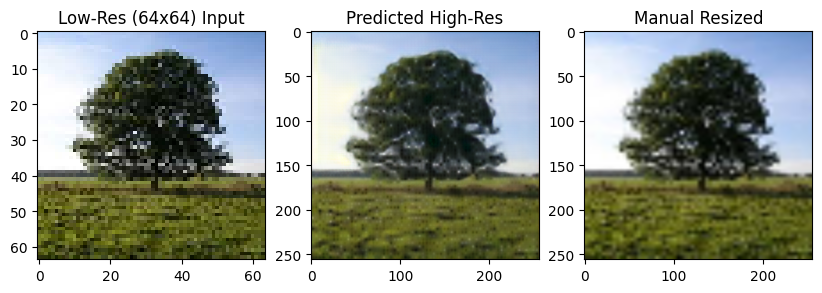

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import tensorflow as tf

def upscale_new_image(model, image_path, target_size=(64, 64), downscale_factor=4):
    # Load the new image and resize it to 64x64
    img = img_to_array(load_img(image_path, target_size=target_size))

    # Create low-res version by downscaling (to simulate the low-res input for the model)
    low_res = cv2.resize(img, target_size)


    # Normalize the images
    low_res = low_res / 255.0
    img = img / 255.0

    # Expand dimensions for batch processing
    low_res = np.expand_dims(low_res, axis=0)

    # Make prediction using the model
    pred = model.predict(low_res)

    # Return both the resized low-res image and the prediction
    return low_res[0], pred[0]

# Example usage
image_path = "test1.jpg"
low_res, predicted = upscale_new_image(model, image_path,target_size=TARGET_SIZE_LOW)

# Display the results
plt.figure(figsize=(10, 5))

# Display the low-resolution (64x64) input
plt.subplot(1, 3, 1)
plt.imshow(low_res)
plt.title("Low-Res (64x64) Input")

# Display the predicted high-resolution image
plt.subplot(1, 3, 2)
plt.imshow(predicted)
plt.title("Predicted High-Res")

plt.subplot(1, 3, 3)
new_res=cv2.resize(low_res,(256,256))
plt.imshow(new_res)
plt.title("Manual Resized")



plt.show()



Sace and use later

In [ ]:
# Save the model in H5 format
model.save("upscaler_model.keras")


In [ ]:
loaded_model = tf.keras.models.load_model("upscaler_model.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 24 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


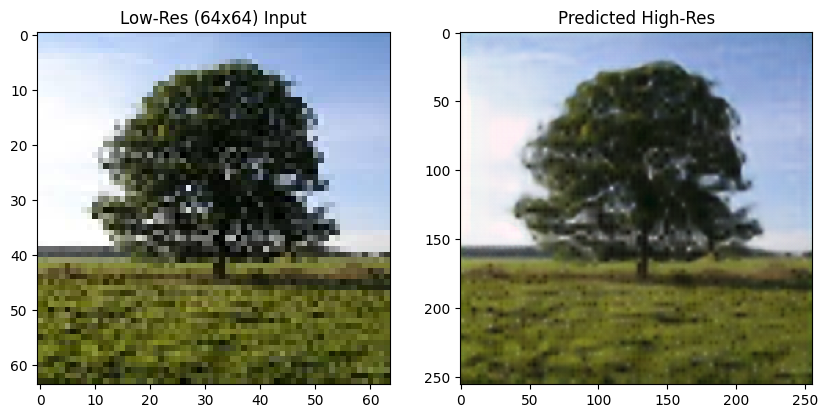

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import tensorflow as tf

def upscale_new_image(model, image_path, target_size=(64, 64), downscale_factor=4):
    # Load the new image and resize it to 64x64
    img = img_to_array(load_img(image_path, target_size=target_size))

    # Create low-res version by downscaling (to simulate the low-res input for the model)
    low_res = cv2.resize(img, (64, 64))

    # Normalize the images
    low_res = low_res / 255.0
    img = img / 255.0

    # Expand dimensions for batch processing
    low_res = np.expand_dims(low_res, axis=0)

    # Make prediction using the model
    pred = model.predict(low_res)

    # Return both the resized low-res image and the prediction
    return low_res[0], pred[0]

# Example usage
image_path = "test1.jpg"

# Predict with the Loaded model
low_res, predicted = upscale_new_image(loaded_model, image_path)

# Display the results
plt.figure(figsize=(10, 5))

# Display the low-resolution (64x64) input
plt.subplot(1, 2, 1)
plt.imshow(low_res)
plt.title("Low-Res (64x64) Input")

# Display the predicted high-resolution image
plt.subplot(1, 2, 2)
plt.imshow(predicted)
plt.title("Predicted High-Res")

plt.show()


# Farklı Model Mimarileri

In [ ]:
# 32lik Giriş için Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, Conv2DTranspose, Add
from tensorflow.keras.models import Model


def build_upscaler():
    # Input layer (Low-resolution 32x32x3)
    inputs = Input(shape=(32, 32, 3))  # Input size: (32, 32, 3) - 32x32 image with 3 channels (RGB)

    # Initial convolution block (feature extraction)
    x = Conv2D(64, (9, 9), padding="same")(inputs)  # Convolution with a kernel of size (9, 9), 64 filters
    x = LeakyReLU(alpha=0.2)(x)  # Activation using LeakyReLU to prevent vanishing gradients
    x = BatchNormalization()(x)  # Batch normalization to stabilize training

    # Size after this block: (32, 32, 64)

    # Feature extraction block with more filters
    x = Conv2D(128, (5, 5), padding="same")(x)  # Convolution with kernel size (5, 5), 128 filters
    x = LeakyReLU(alpha=0.2)(x)  # LeakyReLU activation
    x = BatchNormalization()(x)  # Batch normalization to help with faster convergence

    # Size after this block: (32, 32, 128)

    # Upscaling to 64x64 using transposed convolutions
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")(x)  # Transposed conv: 32x32 → 64x64
    x = LeakyReLU(alpha=0.2)(x)  # LeakyReLU activation
    x = BatchNormalization()(x)  # Batch normalization

    # Size after this block: (64, 64, 128)

    # Further upscaling to 128x128
    x = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same")(x)  # Transposed conv: 64x64 → 128x128
    x = LeakyReLU(alpha=0.2)(x)  # LeakyReLU activation
    x = BatchNormalization()(x)  # Batch normalization

    # Size after this block: (128, 128, 64)

    # Additional upscaling to 256x256
    x = Conv2DTranspose(32, (4, 4), strides=(2, 2), padding="same")(x)  # Transposed conv: 128x128 → 256x256
    x = LeakyReLU(alpha=0.2)(x)  # LeakyReLU activation
    x = BatchNormalization()(x)  # Batch normalization

    # Size after this block: (256, 256, 32)

    # Residual connection to preserve fine details
    residual = Conv2D(32, (5, 5), padding="same")(x)  # Convolution to extract finer details
    residual = LeakyReLU(alpha=0.2)(residual)  # LeakyReLU activation
    residual = BatchNormalization()(residual)  # Batch normalization

    # Residual connection: Adding the original feature map to the transformed feature map
    x = Add()([x, residual])  # The residual helps preserve finer details and avoid blurriness

    # Size after this block: (256, 256, 32)

    # Final convolution layer to output 256x256 RGB image (3 channels)
    outputs = Conv2D(3, (5, 5), padding="same", activation="sigmoid")(x)  # Final conv: 256x256 → 256x256 with 3 channels

    # Size after this block: (256, 256, 3)

    # Create the model
    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])  # Compile model with Adam optimizer and MSE loss

    return model

# Instantiate and summarize the model
model = build_upscaler()
model.summary()  # Summary shows the architecture details and layer output sizes


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         15,616 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_5 (LeakyReLU) │ (None, 32, 32, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 32, 32, 64)     │            256 │ leaky_re_lu_5[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 128)    │        204,928 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_6 (LeakyReLU) │ (None, 32, 32, 128)    │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 32, 32, 128)    │            512 │ leaky_re_lu_6[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_2        │ (None, 64, 64, 128)    │        262,272 │ batch_normalization_6… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_7 (LeakyReLU) │ (None, 64, 64, 128)    │              0 │ conv2d_transpose_2[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 64, 64, 128)    │            512 │ leaky_re_lu_7[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_3        │ (None, 128, 128, 64)   │        131,136 │ batch_normalization_7… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_8 (LeakyReLU) │ (None, 128, 128, 64)   │              0 │ conv2d_transpose_3[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 128, 128, 64)   │            256 │ leaky_re_lu_8[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 256, 256, 32)   │         32,800 │ batch_normalization_8… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_9 (LeakyReLU) │ (None, 256, 256, 32)   │              0 │ conv2d_transpose_4[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9

 Total params: 676,579 (2.58 MB)

 Trainable params: 675,683 (2.58 MB)

 Non-trainable params: 896 (3.50 KB)

Eğer Ram Sorunun Varsa


In [ ]:
# Ram Dostu Model 64->256
from tensorflow.keras.layers import Conv2D, LeakyReLU, Add, Input, UpSampling2D, BatchNormalization
from tensorflow.keras.models import Model

def build_balanced_upscaler():
    # Input layer
    inputs = Input(shape=(64, 64, 3))

    # Initial convolution block
    x = Conv2D(48, (9, 9), padding="same")(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    # Feature extraction block
    x = Conv2D(96, (5, 5), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    # Upscaling to 128x128
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(96, (3, 3), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    # Upscaling to 256x256
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(48, (3, 3), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)

    # Residual connection
    residual = Conv2D(48, (3, 3), padding="same")(x)
    residual = LeakyReLU(alpha=0.2)(residual)
    x = Add()([x, residual])

    # Final output layer
    outputs = Conv2D(3, (5, 5), padding="same", activation="sigmoid")(x)

    # Create the model
    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])

    return model

# Instantiate and summarize the model
model = build_balanced_upscaler()
model.summary()
